Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 

Read in the necessary data

In [2]:
player_totals=pd.read_csv('./data/Player Totals.csv')
player_career_info=pd.read_csv('./data/Player Career Info.csv')
advanced=pd.read_csv('./data/Advanced.csv')
clean=pd.read_csv('./data/NBA_players_clean.csv')

hof=player_career_info.drop(['birth_year','num_seasons'],axis=1)
player_names_and_seasons=hof[['player','first_seas','last_seas','player_id']]

Make a dictionary containing the top 10 list for every season for every major category

In [3]:
seasons = np.flip(player_totals.season.unique())
seasons_leaderboards = {}
for season in seasons:
    season_top10s = {'pts': player_totals[player_totals['season'] == season].sort_values(by=['pts']).tail(10),
                     'reb': player_totals[player_totals['season'] == season].sort_values(by=['trb']).tail(10),
                     'ast': player_totals[player_totals['season'] == season].sort_values(by=['ast']).tail(10),
                     'min': player_totals[player_totals['season'] == season].sort_values(by=['mp']).tail(10),
                     'stl': player_totals[player_totals['season'] == season].sort_values(by=['stl']).tail(10),
                     'blk': player_totals[player_totals['season'] == season].sort_values(by=['blk']).tail(10)}
    seasons_leaderboards[season] = season_top10s

Calculate leaderboard points giving a player 5 points for making the top 10 and up to 2 points extra depending on the spot in the top 10

In [4]:
leaderboard_points=[]
for i in range(len(player_names_and_seasons)):
    x=0
    for season in range(player_names_and_seasons.iloc[i].first_seas,player_names_and_seasons.iloc[i].last_seas+1):
        top10_pts = seasons_leaderboards[season]['pts']
        top10_reb = seasons_leaderboards[season]['reb']
        top10_ast = seasons_leaderboards[season]['ast']
        top10_min = seasons_leaderboards[season]['min']
        top10_stl = seasons_leaderboards[season]['stl']
        top10_blk = seasons_leaderboards[season]['blk']
        for j in range(9,-1,-1):
            if top10_pts.iloc[j].player_id == player_names_and_seasons.iloc[i].player_id:
                x+=(5 + j/2)
            if top10_reb.iloc[j].player_id == player_names_and_seasons.iloc[i].player_id:
                x+=(5 + j/2)
            if top10_ast.iloc[j].player_id == player_names_and_seasons.iloc[i].player_id:
                x+=(5 + j/2)
            if top10_min.iloc[j].player_id == player_names_and_seasons.iloc[i].player_id:
                x+=(5 + j/2)
            if top10_stl.iloc[j].player_id == player_names_and_seasons.iloc[i].player_id:
                x+=(5 + j/2)
            if top10_blk.iloc[j].player_id == player_names_and_seasons.iloc[i].player_id:
                x+=(5 + j/2)
    leaderboard_points.append(x)
    
hof['Leaderboard points']=leaderboard_points        

Cleaning the "clean" database by removing asterisks from player names containing them

In [5]:
clean['Player']

0             Alaa Abdelnaby
1            Zaid Abdul-Aziz
2       Kareem Abdul-Jabbar*
3         Mahmoud Abdul-Rauf
4          Tariq Abdul-Wahad
                ...         
5018              Ante Žižić
5019                Jim Zoet
5020               Bill Zopf
5021             Ivica Zubac
5022              Matt Zunic
Name: Player, Length: 5023, dtype: object

In [6]:
def cut_string(name):
    if '*' in name:
        return name.split('*')[0]
    return name
clean['player']=clean['Player'].apply(lambda x:cut_string(x))

In [7]:
clean['player']

0            Alaa Abdelnaby
1           Zaid Abdul-Aziz
2       Kareem Abdul-Jabbar
3        Mahmoud Abdul-Rauf
4         Tariq Abdul-Wahad
               ...         
5018             Ante Žižić
5019               Jim Zoet
5020              Bill Zopf
5021            Ivica Zubac
5022             Matt Zunic
Name: player, Length: 5023, dtype: object

Adding all the mostly known career stats the dataframe "hof" which we are going to fit the model on

In [8]:
career_stats = {
    'Height': 'height',
    'Wt': 'weight',
    'G': 'games',
    'PTS': 'points',
    'TRB': 'total rebounds',
    'AST': 'total assists',
    'FG%': 'field goal percentage',
    'FG3%': '3-point field goal percentage',
    'FT%': 'free throw percentage',
    'eFG%': 'Effective Field Goal Percentage',
    'All Star': 'All-Star selections',
    'All NBA': 'All-NBA selections',
    'All ABA': 'all ABA selections',
    'All Rookie': 'all rookie team selections',
    'All Defensive': 'all defensive team selections',
    'Most Improved': 'most improved player of the year wins',
    'Sixth Man': 'sixth man of the year wins',
    'DPOY': 'defensive player of the year wins',
    'ROY': 'rookie of the year wins',
    'AS MVP': 'all star game MVP wins',
    'CF MVP': 'conference finals MVP wins',
    'Finals MVP': 'finals MVP wins',
    'MVP': 'most valuable player of the year wins',
    'Championships': 'championships'
}

for career_stat in career_stats:
    counts = []

    for index, player in player_names_and_seasons.iterrows():
        count = 0
    
        clean_players=clean[clean.player==player.player]

        for index2, clean_player in clean_players.iterrows():
            if clean_player.From == player.first_seas and clean_player.To <= player.last_seas:
                count = clean_player[career_stat]
            
        counts.append(count)

    colName = career_stats[career_stat]
    hof[colName] = counts

Adding also the lesser known but still very important advanced metric stats provided by the NBA

In [9]:
advanced_stat_cols = {
    'vorp': 'value over replacement player',
    'bpm': 'box plus minus',
    'dbpm': 'defensive box plus minus',
    'obpm': 'offensive box plus minus',
    'ws_48': 'win shares per 48 minutes',
    'ws': 'win shares',
    'dws': 'defensive win shares',
    'ows': 'offensive win shares',
    'usg_percent': 'usage percentage',
    'tov_percent': 'turnover percentage',
    'blk_percent': 'block percentage',
    'stl_percent': 'steal percentage',
    'ast_percent': 'assist percentage',
    'trb_percent': 'total rebounds percentage',
    'drb_percent': 'defensive rebounds percentage',
    'orb_percent': 'offensive rebounds percentage',
    'f_tr': 'free throw rate',
    'x3p_ar': 'three point attempt rate',
    'ts_percent': 'true shooting percentage',
    'per': 'player efficiency rating'
}

for stat in advanced_stat_cols:
    best5Avgs = []

    for player in player_names_and_seasons.player_id:
        best5Avgs.append(advanced[advanced['player_id']==player].nlargest(5, stat)[stat].mean())

    columnName = 'Average of 5 highest {col} seasons'.format(col = advanced_stat_cols[stat])
    hof[columnName]=best5Avgs

    hof[columnName] = hof[columnName].fillna(hof[columnName].mean())



Converting True and False values to 1 and 0 respectively

In [10]:
hof['hof'] = hof['hof'].astype(int)

Selecting the dataset containing old players which we are going to split into training and test sets. Also selecting the current players which we are going to perform our prediction on

In [11]:
young=hof[(hof['last_seas']>=2023)]
old=hof[hof['last_seas']<=2009]

Using the standard scaler we are going to make sure that the units are in the same scale for all features. That allows us to later decide which features are most important

In [12]:
X=old.drop(['first_seas','last_seas','hof','player','player_id'],axis=1)
y=old['hof']
X_scaled= StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_pred=young.drop(['first_seas','last_seas','hof','player','player_id'],axis=1)
X_pred_scaled =StandardScaler().fit_transform(X_pred)
X_pred = pd.DataFrame(X_pred_scaled, columns=X_pred.columns, index=X_pred.index)
y_pred=young['hof']

Split the data to have training and test set. Then create 3 different models: Logistic Regression, Random Forest and KNN

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
knn_prob=knn.predict_proba(X_pred)[:,-1]

logmodel=LogisticRegression(max_iter=10000)
logmodel.fit(X_train,y_train)
pred_log=logmodel.predict(X_test)
log_prob=logmodel.predict_proba(X_pred)[:,-1]

rfc=RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
pred_rfc=rfc.predict(X_test)
rfc_prob=rfc.predict_proba(X_pred)[:,-1]

C:\Users\arxer\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Create a plot to illustrate the models' accuracy with MSE

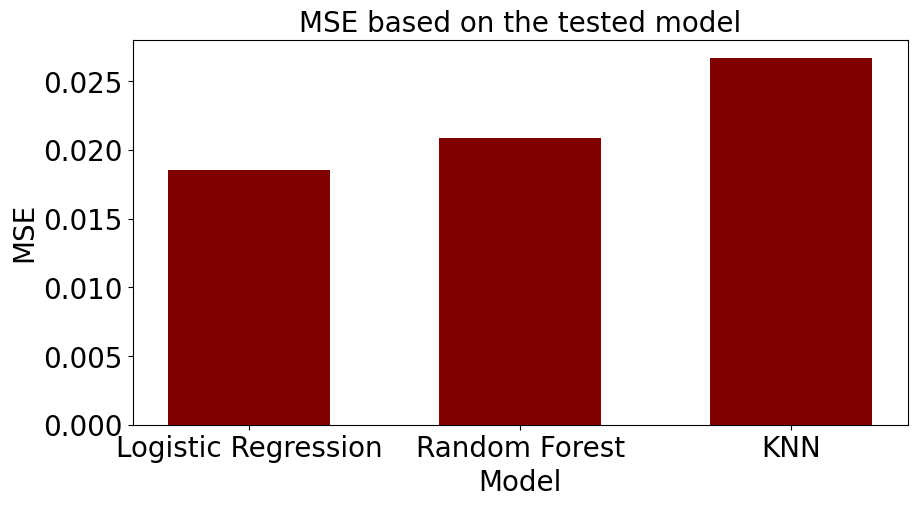

In [14]:
data = {'Logistic Regression':mean_squared_error(pred_log, y_test), 'Random Forest':mean_squared_error(pred_rfc, y_test), 
        'KNN':mean_squared_error(pred_knn, y_test)}
models = list(data.keys())
mses = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
plt.bar(models, mses, color ='maroon', width = 0.6)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.xlabel("Model", fontsize= 20)
plt.ylabel("MSE", fontsize= 20)
plt.title("MSE based on the tested model", fontsize=20)
plt.show()

Finding our most accurate model's MSE score

In [15]:
print(data['Logistic Regression'])

0.018561484918793503


Set necessary data columns back together

In [16]:
res=pd.concat([X_pred,y_pred],axis=1)
res['log_prob']=log_prob
res['rfc_prob']=rfc_prob
res['knn_prob']=knn_prob
res_final=pd.concat([res,hof['player']],axis=1).dropna()

Find out most important features and select five of the most important ones

In [17]:
features_sorted = pd.DataFrame(logmodel.coef_, columns=X_train.columns).transpose().sort_values(by=[0], key=abs, ascending=False)

In [18]:
five_most_important_features = features_sorted.head(5)
five_most_important_features.rename(columns={0: "Coefficient"},inplace=True)
five_most_important_features.index.name = 'Feature'
five_most_important_features.to_csv("features.csv")
five_most_important_features

C:\Users\arxer\AppData\Local\Temp\ipykernel_30620\3856026996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_most_important_features.rename(columns={0: "Coefficient"},inplace=True)


,Coefficient
Feature,
All-Star selections,1.028245
Average of 5 highest offensive rebounds percentage seasons,-0.832161
Effective Field Goal Percentage,0.673303
All-NBA selections,0.557544
Average of 5 highest win shares per 48 minutes seasons,0.521342


Find out the likeliest players to make the Hall of Fame and select 10 of the likeliest

In [19]:
final = res_final[['player','log_prob']]
final.sort_values(by=['log_prob'],ascending=False)

,player,log_prob
3462,LeBron James,1.000000e+00
3769,Kevin Durant,9.999998e-01
3902,Stephen Curry,9.999968e-01
3584,Chris Paul,9.999017e-01
4163,Giannis Antetokounmpo,9.992578e-01
...,...,...
5156,Trayce Jackson-Davis,1.596070e-05
5027,Alondes Williams,9.721238e-06
5083,Moussa Diabaté,2.863964e-06
5034,Chima Moneke,1.116114e-06


In [20]:
table = final.sort_values(by=['log_prob'],ascending=False).head(10)
table.rename(columns={"player": "Name", "log_prob": "Probability"},inplace=True)
table.to_csv("probs.csv", index=False)
table.set_index(keys="Name")

,Probability
Name,
LeBron James,1.000000
Kevin Durant,1.000000
Stephen Curry,0.999997
Chris Paul,0.999902
Giannis Antetokounmpo,0.999258
Russell Westbrook,0.998588
James Harden,0.997840
Kawhi Leonard,0.997772
Anthony Davis,0.968183
